# HKL calculation, compared to SPEC results

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gi
gi.require_version('Hkl', '5.0')

from hkl.calc import CalcE6C

## Load the desired HKL trajectory

In [2]:
hkls = pd.read_csv('hkl_data/hkl.txt', delim_whitespace=True)
hkls.keys()

Index(['h', 'k', 'l'], dtype='object')

## Get the motor positions that SPEC calculated

In [3]:
# The motor positions according to SPEC
spec_motors = pd.read_csv('hkl_data/motors.txt', delim_whitespace=True)
spec_motors.keys()

Index(['Delta', 'Theta', 'Chi', 'Phi', 'Mu', 'Gamma'], dtype='object')

## Plot the trajectory of the physical motors

<IPython.core.display.Javascript object>


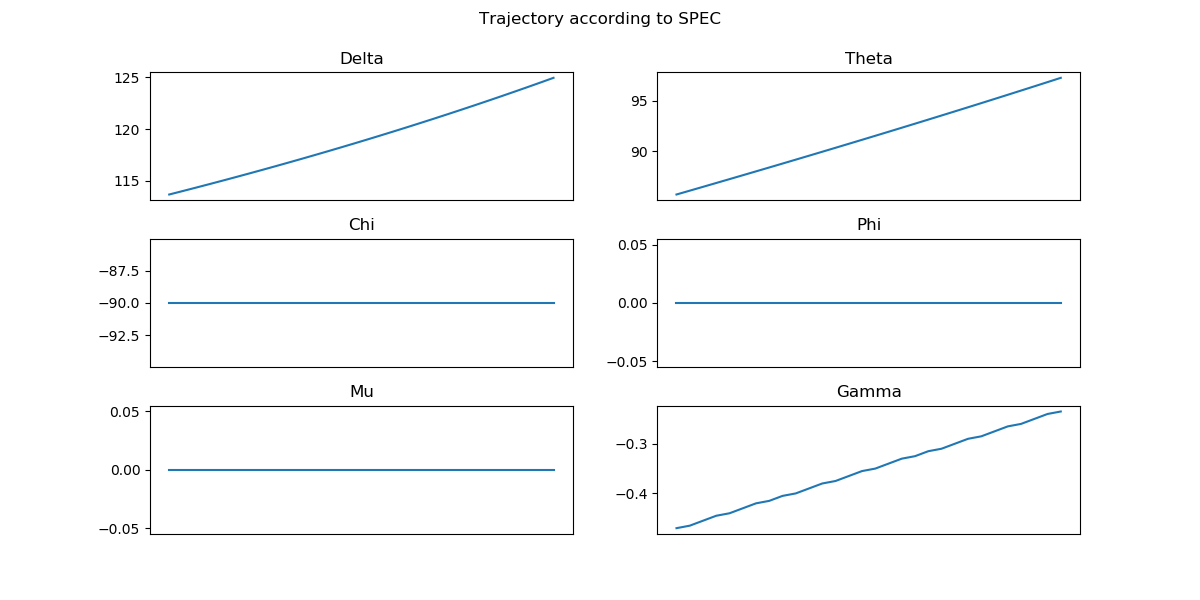

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6),
                         subplot_kw={'xticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.suptitle('Trajectory according to SPEC')
for ax, key in zip(axes.flat, spec_motors.keys()):
    ax.plot(spec_motors.index, spec_motors[key], label=key)
    ax.set_title(key)
plt.show()

## Plot the desired HKL trajectory

<IPython.core.display.Javascript object>


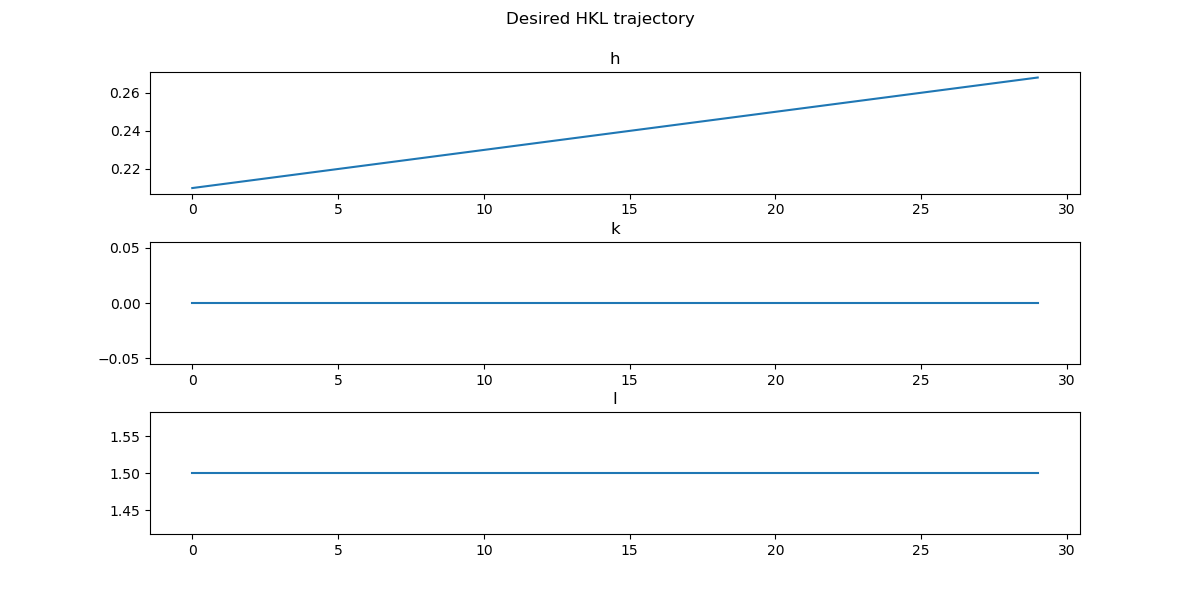

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.suptitle('Desired HKL trajectory')
axes[0].plot(hkls.h)
axes[0].set_title('h')
axes[1].plot(hkls.k)
axes[1].set_title('k')
axes[2].plot(hkls.l)
axes[2].set_title('l')
plt.show()

## Initialize a calculation engine

In [6]:
sixc_calc = CalcE6C(engine='hkl')
sixc_calc.wavelength = 13.3  # angstrom
print('mode is', sixc_calc.engine.mode)
print('physical axes', sixc_calc.physical_axes)
print('pseudo axes', sixc_calc.pseudo_axes)
print('omega parameter is', sixc_calc['omega'])

mode is bissector_vertical
physical axes OrderedDict([('mu', 0.0), ('omega', 0.0), ('chi', 0.0), ('phi', 0.0), ('gamma', 0.0), ('delta', 0.0)])
pseudo axes OrderedDict([('h', 0.0), ('k', 0.0), ('l', 0.0)])
omega parameter is CalcParameter(name='omega', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')


## Set some constraints on the physical motors

In [7]:
phi = sixc_calc['phi']
phi.limits = (0, 0)
phi.value = 0
phi.fit = False

chi = sixc_calc['chi']
chi.limits = (-90, -90)
chi.value = -90
chi.fit = False

mu = sixc_calc['mu']
mu.limits = (0, 0)
mu.value = 0
mu.fit = False

print('phi', sixc_calc['phi'])
print('chi', sixc_calc['chi'])
print('mu', sixc_calc['mu'])

phi CalcParameter(name='phi', limits=(0.0, 0.0), value=0.0, fit=False, inverted=False, units='Degree')
chi CalcParameter(name='chi', limits=(-90.0, -90.0), value=-90.0, fit=False, inverted=False, units='Degree')
mu CalcParameter(name='mu', limits=(0.0, 0.0), value=0.0, fit=False, inverted=False, units='Degree')


# Add a sample to work with

In [8]:
from hkl.util import Lattice
lattice = Lattice(a=3.78, b=3.78, c=13.28, alpha=90, beta=90, gamma=90)
sample = sixc_calc.new_sample('sample0', lattice=lattice)

## Primary reflection

In [9]:
p1 = sixc_calc.Position(mu=0.0, omega=71.04, chi=-90.0, phi=0.0, gamma=-1.65, delta=136.7)
r1 = sample.add_reflection(0, 0, 2, position=p1)

## Secondary reflection

In [10]:
p2 = sixc_calc.Position(mu=0.0, omega=158.22, chi=-90.0, phi=0.0, gamma=1.7, delta=164.94)
r2 = sample.add_reflection(1, 0, 1, position=p2)

## Calculate the UB matrix

In [11]:
sample.compute_UB(r1, r2)
print(np.array(sample.UB))

spec_ub = [[0.0338309723166807, 1.6616745234937, -0.00732930331262271],
           [1.66007365775423, -0.032591767600211, 0.0221634966739925],
           [0.0773350510852808, -0.0273010739795478, -0.472555187096841]
           ]
print('from spec:\n', np.array(spec_ub))

[[ 1.66011306  0.0298982   0.02223195]
 [ 0.07775045  0.02016382 -0.4725787 ]
 [-0.03081074  1.6618271   0.00533407]]
from spec:
 [[ 0.03383097  1.66167452 -0.0073293 ]
 [ 1.66007366 -0.03259177  0.0221635 ]
 [ 0.07733505 -0.02730107 -0.47255519]]


## Calculate the trajectory

In [12]:
for seq, (h, k, l) in hkls.iterrows():
    print('-- hkl {} --'.format((h, k, l)))
    print('Solutions:')
    try:
        solutions = sixc_calc.forward((h, k, l))
        for sol in solutions:
            print('\t{}'.format(sol))
    except Exception as exc:
        print("No solutions:", exc)
        
    break

-- hkl (0.21, 0.0, 1.5) --
Solutions:
No solutions: Calculation failed (hkl-engine-error-quark: no remaining solutions (4))
